# Import Libraries

In [2]:
import requests
import glob
import os
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from functools import reduce
from ta.momentum import rsi
from ta.trend import ema_indicator
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import coint

# Data Collection

In [3]:
all_markets = ["BTC", "ETH", "DOGE", "BNB", "XRP", "TRX", "ZIL", "ADA", "WAVES", "ETC", "LTC", "MATIC", "LINK", "EOS", "ATOM", "XLM"]
col_list = ["open_time", "open", "high", "low", "close", "volume", "close_time", "quote_asset_volume", "number_of_trade", "ignore1", "ignore2", "ignore3"]

directory = "data/"
if not os.path.exists(directory):
    os.makedirs(directory)

for market in all_markets:
    df = pd.DataFrame(columns=col_list)
    startTime = 1622419200000  # 2021-05-31 00:00:00 -> 1 month for cointegration test + 1 day for technical indicator
    endTime = 1648684800000    # 2022-03-31 23:59:59
    while startTime < endTime:
        url = f"https://api.binance.com/api/v3/klines?symbol={market}USDT&interval=1m&startTime={startTime}&limit=1000"
        data = pd.DataFrame(requests.get(url).json(), columns=col_list)
        df = pd.concat([df, data])
        startTime = df.close_time.iloc[-1] + 1
    df.to_csv(f"data/{market}.csv")

# Formatting CSV File into ohlcv

In [4]:
token_list = ["BTC", "ETH", "DOGE", "BNB", "XRP", "TRX", "ZIL", "ADA", "WAVES", "ETC", "LTC", "MATIC", "LINK", "EOS", "ATOM", "XLM"]
for i in glob.glob("data/*.csv"):
    df = pd.read_csv(i, index_col=0)
    df["time"] = (df["open_time"]/1000).apply(datetime.utcfromtimestamp)
    df.set_index("time", drop=True, inplace=True)
    df = df[["open", "high", "low", "close", "quote_asset_volume"]]
    df.columns = ["open", "high", "low", "close", "volume"]
    df.to_csv(i)

# Aligning Time & Backfill Missing Data

In [9]:
df_list = []
for i in glob.glob("data/*.csv"):
    token_name = i.split("\\")[1].split(".")[0]
    df = pd.read_csv(i, index_col=0)
    col = [token_name + "_" + col_name for col_name in df.columns]
    df.columns = col
    df_list.append(df)

master_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how="outer"), df_list)
master_df.fillna(method="ffill", inplace=True)
master_df = master_df.loc[:"2022-04-01"]

# splitting back into individual csv files
for token in token_list:
    cols = [col for col in master_df.columns if col.startswith(token)]
    df = master_df[cols]
    df.columns = [col.split("_")[1] for col in cols]
    df.to_csv(f"data/{token}.csv")

In [10]:
# populating features & confining time index to predetermined time horizon
for i in glob.glob("data/*.csv"):
    df = pd.read_csv(i, index_col=0, parse_dates=True)
    df["log_rtn"] = np.log(df["close"]).diff()
    for window in [30, 60, 240, 480, 720, 1440]:
        df[f"{window}_ema"] = ema_indicator(df.close, window)
        df[f"{window}_rsi"] = rsi(df.close, window)
        df[f"{window}_vol"] = df["log_rtn"].rolling(window).std()
    df = df.loc["2021-06-01":"2022-03-31"]
    df.to_csv(i)

In [11]:
##################################################################################
###########  END OF DATA ACQUISITION - DO NOT RUN CODE ABOVE THIS CELL ###########
##################################################################################

# Reading Data

In [19]:
token_list = ["BTC", "ETH", "DOGE", "BNB", "XRP", "TRX", "ZIL", "ADA", "WAVES", "ETC", "LTC", "MATIC", "LINK", "EOS", "ATOM", "XLM"]
pre_data = {}
data = {}
for token in token_list:
    df = pd.read_csv(f"data/{token}.csv", index_col=0, parse_dates=True)
    pre_data[token] = df.loc[:"2021-06-30"]
    data[token] = df.loc["2021-07-01":]

In [20]:
# clustering using NearestNeighbor using the first data point
# getting the cluster data
cluster_data = pd.DataFrame(columns=token_list)
for token in token_list:
    cluster_data[token] = pre_data[token].iloc[0]
cluster_data = cluster_data.T

# NearestNeighbor
nn = NearestNeighbors(n_neighbors=4)
nn.fit(cluster_data)
neigh = nn.kneighbors()[1]

# Pairs for cointegration test
token0 = [token for token in token_list for i in range(4)]
token1 = [token_list[i] for i in neigh.ravel()]
pairs = pd.DataFrame()
pairs ["pair"] = [list(a) for a in zip(token0, token1)]
pairs ["rev"] = [list(a) for a in zip(token1, token0)]
drop = []
for i in range(len(pairs)):
    if pairs.iloc[i]["rev"] in pairs["pair"].to_list()[i:]:
        drop.append(i)
pairs = pairs.drop(drop, axis=0)["pair"].reset_index(drop=True).to_list()
len(pairs)

38

In [21]:
# cointegration test for all pairs
coint_pairs = []
coint_tstat = []
for pair in pairs:
    price0 = pre_data[pair[0]]["close"]
    price1 = pre_data[pair[1]]["close"]
    res = coint(price0, price1)
    tstat, pval = res[0], res[1]
    if pval < 0.05:
        coint_pairs.append(pair)
        coint_tstat.append(tstat)
        print(f"{pair[0]} - {pair[1]}")
        print(f"It is co integrated with pval - {pval}, tstat - {tstat}")
        print()

DOGE - ZIL
It is co integrated with pval - 0.005075233287070696, tstat - -4.104010893265749

XRP - BNB
It is co integrated with pval - 0.00026455640679246223, tstat - -4.886678326778146

ADA - BNB
It is co integrated with pval - 0.020962227093312198, tstat - -3.654189493188166

ADA - XRP
It is co integrated with pval - 0.01810691583983802, tstat - -3.7040492141361656

ADA - LINK
It is co integrated with pval - 0.004309592944557986, tstat - -4.151885073323576

LTC - DOGE
It is co integrated with pval - 0.008269385419192228, tstat - -3.9567262774242624

LTC - ZIL
It is co integrated with pval - 0.0035177993305641523, tstat - -4.2103866269319905

MATIC - BNB
It is co integrated with pval - 0.020827105793967488, tstat - -3.656411422242148

LINK - BNB
It is co integrated with pval - 0.0021207890272936527, tstat - -4.352106831201821

EOS - DOGE
It is co integrated with pval - 4.228519337955496e-05, tstat - -5.311655110648428

EOS - ZIL
It is co integrated with pval - 2.9909369695857418e-05, 

In [22]:
# choosing the most cointegrated pairs - EOS-ZIL
coint_df = pd.DataFrame({"pairs": coint_pairs,
                         "tstat": coint_tstat})
coint_df.sort_values(by="tstat", ascending=True).reset_index(drop=True)

,pairs,tstat
0,"[EOS, ZIL]",-5.388334
1,"[EOS, DOGE]",-5.311655
2,"[XRP, BNB]",-4.886678
3,"[ATOM, ZIL]",-4.529478
4,"[XLM, ZIL]",-4.370721
5,"[LINK, BNB]",-4.352107
6,"[LTC, ZIL]",-4.210387
7,"[ADA, LINK]",-4.151885
8,"[DOGE, ZIL]",-4.104011
9,"[LTC, DOGE]",-3.956726


In [51]:
# Finding hedge ratio for each of the cointegrated pairs using OLS regression - using more expensive token as y
# EOS-ZIL
lr1 = LinearRegression()
lr1.fit(pre_data["ZIL"]["close"].values.reshape(-1,1), pre_data["EOS"]["close"])
print(f"1 EOS = {float(lr1.coef_)} ZIL")
print()

1 EOS = 44.365611877994155 ZIL



In [62]:
# code snippet for denoising with wavelet transform demonstration with close price of ZIL
denoised_coeff = []
filt = pywt.Wavelet("haar")
max_level = pywt.dwt_max_level(len(data["ZIL"]), filt.dec_len)
series = pywt.wavedec(data["ZIL"].close, "haar", level=2) # choose the level depending on how "strong" the filtering you want to be, larger value = more smoothing, between 2 to max_level
for i in series:
    denoise = pywt.threshold(i, np.std(i))
    denoised_coeff.append(denoise)
denoised_signal = pywt.waverec(denoised_coeff, "haar")

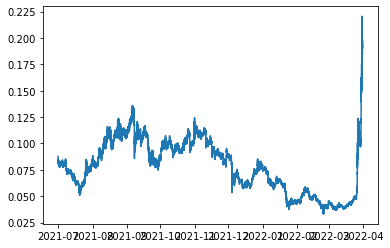

In [63]:
# original signal
plt.plot(data["ZIL"].close)

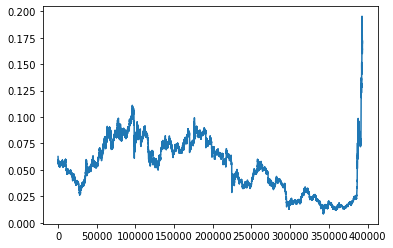

In [64]:
# denoised signal
plt.plot(denoised_signal)